In [3]:
#conda environment: pokus_py4DSTEM 
#abtem version: 4d630003af7a2d33ee63e9a02f1846549d04be00

import os
os.environ["MKL_NUM_THREADS"] = "16"
os.environ["NUMEXPR_NUM_THREADS"] = "16"
os.environ["OMP_NUM_THREADS"] = "16"

import numpy as np
import matplotlib.pyplot as plt
from abtem import *

from abtem.noise import poisson_noise
import scipy.constants as c
from abtem.scan import PositionScan
from abtem.reconstruct import invms
from abtem.measure import bandlimit

from abtem.custom import get_gaussian_spread
from abtem.custom import get_radiation_dose
from abtem.custom import incoherent_scan
from abtem.custom import incoherent_scan_mc
from abtem.custom import sample_probe
from abtem.custom import incoherent_scan_mc_fp
from abtem.custom import incoherent_probe, get_probe_radius
from abtem.custom import crop
from abtem.custom import semiangle_2_sampling_extent,semiangle_gpts_2_extent
from abtem.custom import decimate_measurement
from abtem.utils import fft_crop,fft_shift
import cupy as cp
import h5py
import pathlib

import matplotlib

import sys 
sys.path.append("../16_registration")
from sample import gen_rnd_tubes

sys.path.append("../07_deep_stem/02_simulated_testing_data_LINK") #07_deep_stem: d27c25c5c9ef530e93488680ca3c1a0b797a2e80
from utils import get_positions, get_downsampled_phase, get_downsampled_mask
from materials.utils import get_potential_from_atoms

from py4DSTEM.process.utils.cross_correlate import align_images_fourier
from skimage.registration import phase_cross_correlation

import py4DSTEM

In [4]:
60e-3

0.06

In [5]:
energy = 60e3 
semiangle_cutoff = 60#15.0

In [6]:
px_size = 56e-6
px_num = 192/2# 192 - Arina
camera_length = 240e-3
#angular_sampling = px_size/camera_length*1e3 # in mrad
angular_sampling = 2*60*2/px_num
angular_extent = angular_sampling * px_num/2  # only semi angle

In [7]:
######
probe_dummy = Probe(energy=energy)
calc_fov = 1/(angular_sampling*1e-3*1/probe_dummy.wavelength)

print("calculation FOV:",calc_fov," angström")
D=calc_fov/2
defocus_half_fov=D/2/(semiangle_cutoff*1e-3)
print("defocus: ",defocus_half_fov ," angström")
print("defocus*2/3: ",defocus_half_fov*2/3 ," angström")

print("probe diameter from defocus: ",2*defocus_half_fov*2/3*semiangle_cutoff*1e-3,'angström')
######

calculation FOV: 19.464241916161193  angström
defocus:  81.10100798400497  angström
defocus*2/3:  54.06733865600331  angström
probe diameter from defocus:  6.488080638720397 angström


In [8]:
#(1/1.35)/(1/probe_dummy.wavelength)

probe_radius:  3.234733319854075 angström


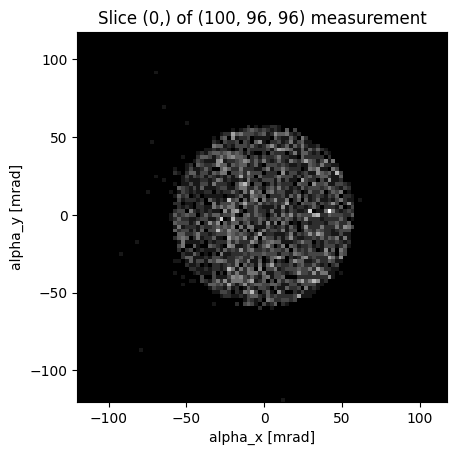

In [9]:
#matplotlib.interactive(True)

#mempool = cp.get_default_memory_pool()


#def run(input_i, output_path,single_patch=False, input_path="data/orig/", input_suffix=".jpg" ,device="gpu"):
if True:
    device = "gpu"
    # Domain

    binning = 1
    reciprocal_oversampling = 2
    direct_oversampling = 4
    sampling, extent = semiangle_2_sampling_extent(angular_extent,px_num/binning,energy=energy,direct_oversampling=direct_oversampling,reciprocal_oversampling=reciprocal_oversampling)

    # Potential, aberrations, probe

    atoms = gen_rnd_tubes(1,N_ = 1,extent=1)#reciprocal_oversampling)
    atoms.set_chemical_symbols(["Ti" for i in range(len(atoms))])
    _,potential=get_potential_from_atoms(atoms,extent=extent,sampling=sampling)
    potential_p=potential.build()
    if potential_p is None:
        assert(True)
        #return(False)    

    #energy_spread = 0.6
    #Cc = 1.34e-3/1e-10
    #focal_spread = energy_spread/energy * Cc # 1/e width of focal distribution
    temporal_sigma = 0#focal_spread/np.sqrt(2) # std of focal distribution (normal distribution is proportional to e**( 1/2*(x/std)**2) )
    #B_r=1e8

    #semiangle_cutoff = 15.0
    alpha=semiangle_cutoff*1e-3

    #aberrations = get_aberrations(scale_all=1,aberrations_set={'C10':350})
    aberrations = {'C10':-defocus_half_fov*2/3,'C30':0e-3/1e-10,'C12':0,'C23':0}
    probe = Probe(energy=energy, semiangle_cutoff=semiangle_cutoff,rolloff=2, **aberrations, device=device,sampling=sampling,extent=extent)

    ##potential_p.project().show()
    ##probe.build().show()
    ##plt.plot(np.abs(probe.build().array[probe.gpts[0]//2,:]).get()**2)

    # Detector, scanning parameters

    detector_p = PixelatedDetector(None)

    #I=50e-12
    spatial_sigma = 0#get_gaussian_spread(probe.ctf.semiangle_cutoff,probe.energy,B_r,I)

    incoh_probe=incoherent_probe(probe,temporal_sigma=temporal_sigma,spatial_sigma=spatial_sigma)
    r, _, _, _= get_probe_radius(probe_measurement=incoh_probe,current_ratio=0.90)
    print("probe_radius: ", r,'angström')
    
    d=2*r
    scan_gpts = 10
    scan_sampling = d*0.15#*np.random.uniform(0.15,0.5)
    positions=get_positions(scan_gpts,np.array(probe.extent),scan_sampling)
    scan_p=PositionScan(positions=positions)

    #|######### Estimating noise

    probe_dummy=probe.copy()
    probe_dummy.sampling=np.array(probe.sampling)*direct_oversampling/2 # 
    incoh_probe_dummy=incoherent_probe(probe_dummy,temporal_sigma=temporal_sigma,spatial_sigma=spatial_sigma)
    if device=="gpu":
        xp=cp
    else:
        xp=np
    max_dose_1,_=get_radiation_dose(incoh_probe_dummy,xp.array(positions),1,fft=False)


    #el=I*100e-6/c.e# number of electrons in diffraction pattern
    targeted_dose = 5000 # el/angstrom
    el = targeted_dose/max_dose_1
    ##print(el)

    phase_downsampled = get_downsampled_phase(potential_p,direct_oversampling,energy=probe.energy)
    if phase_downsampled is None:
        print("No downsampled phase")
        assert(True)
        #return(None)

    probe_dummy_mask=Probe(energy=energy, semiangle_cutoff=probe.ctf.semiangle_cutoff, **aberrations,extent=extent,sampling=sampling)
    mask = get_downsampled_mask(probe_dummy_mask, direct_oversampling, thr_fac = 0.1, positions = positions, temporal_sigma = 0, spatial_sigma = 0)
    #mask_finer = get_downsampled_mask(probe, direct_oversampling//2, thr_fac = 0.1, positions = positions, temporal_sigma = 0, spatial_sigma = 0)
    
    #|######### Measurement

    #measurement=incoherent_scan_mc(probe,positions,detector_p,potential_p,temporal_sigma=temporal_sigma,spatial_sigma=spatial_sigma,max_batch_scan=100) 
    measurement=probe.scan(scan_p,detectors=detector_p,potential=potential_p,max_batch=50,pbar=False)

    measurement_crop=crop(measurement,extent=(angular_extent*2+1e-6,angular_extent*2+1e-6))

    # Downsampling diffraction pattern

    measurement_resampled = decimate_measurement(measurement_crop,reciprocal_oversampling)

    #| Apply noise or dont?

    norm=np.mean(np.sum(measurement.array,(-2,-1))) # average of fraction !uncropped! measurements(should be close to one, but it is a bit less then one cuz some electrons go past antialiasing aperture)
    if 1:
        measurement_noisy = poisson_noise(measurement_resampled/norm, dose=el,pixel_area=1)/el # el can be set based on current and dwell time or better it can be parametrized with targeted dose (el/angstron^2), then el=targeted_dose/max_dose_1, max_dose_1 depends on shape of a probe and step size.
    else:
        measurement_noisy = measurement_resampled

    measurement_noisy.show()
    plt.show()

In [19]:
scan_sampling

0.9704199959562225

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f4ca8813ac0>)

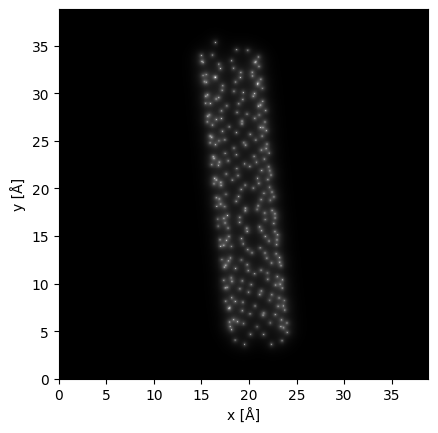

In [11]:
potential.project().show()

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f4c997af5b0>)

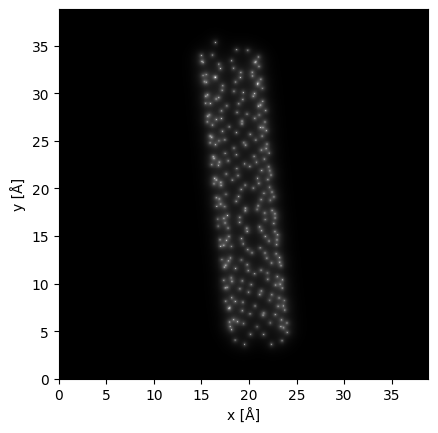

In [12]:
potential.project().show()

(<Axes: xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f4c99630df0>)

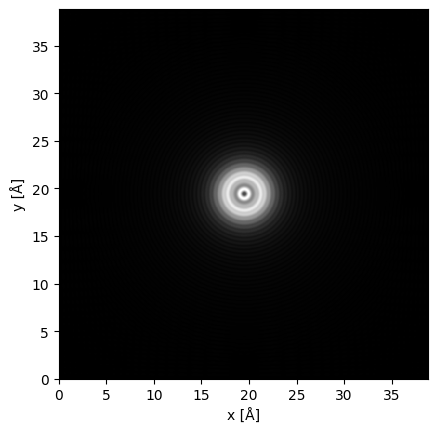

In [13]:
probe.show(power=0.5)

In [14]:
1/probe.wavelength

20.550504957908448

(<Axes: xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7f4c996bc3a0>)

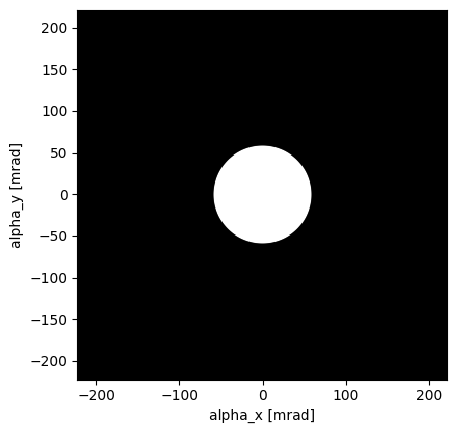

In [15]:
probe.build().diffraction_pattern().show()

(<Axes: title={'center': 'Slice (0,) of (100, 96, 96) measurement'}, xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7f4c99533400>)

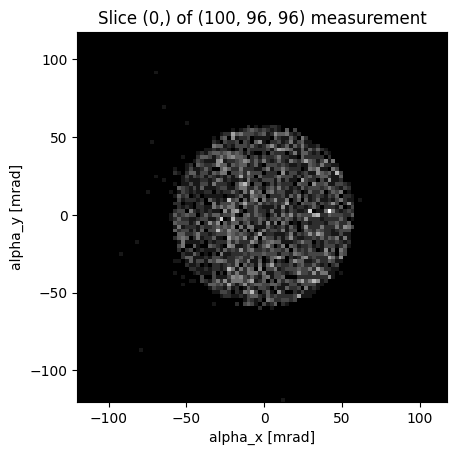

In [16]:
measurement_noisy.show()

In [17]:
60e-3*50

3.0

In [18]:
probe_guess = Probe(semiangle_cutoff=semiangle_cutoff, energy=energy,defocus=-aberrations['C10'],C30=aberrations['C30'],extent=40,gpts=256)

In [24]:
reconstructions = invms(measurement_noisy, probe_guess, positions = positions, modes=1,k_modes=1, alpha=0.1, fac=1, beta=0.1, slices=2, slice_thickness=21,  maxiter=32, return_iterations=True, fix_com=True,device='gpu')

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

probes norm:  [0.91126595] probes norm sum:  0.911265947110514
SSE:  2.747498623939965e-08
probes norm:  [0.89676486] probes norm sum:  0.8967648560930486
SSE:  2.704010678679969e-08
probes norm:  [0.89534449] probes norm sum:  0.8953444913149721
SSE:  2.6808678626799287e-08
probes norm:  [0.8947775] probes norm sum:  0.8947774998514153
SSE:  2.6568885249946586e-08
probes norm:  [0.89460248] probes norm sum:  0.8946024807005817
SSE:  2.6413204502407953e-08
probes norm:  [0.89406829] probes norm sum:  0.8940682949251204
SSE:  2.6300472420059635e-08
probes norm:  [0.89344961] probes norm sum:  0.8934496077766364
SSE:  2.6211369415102125e-08
probes norm:  [0.89272346] probes norm sum:  0.8927234586006468
SSE:  2.6142223895796348e-08
probes norm:  [0.89325736] probes norm sum:  0.8932573601989973
SSE:  2.6120606927632013e-08
probes norm:  [0.89324442] probes norm sum:  0.8932444155355747
SSE:  2.6061922837935337e-08
probes norm:  [0.89286215] probes norm sum:  0.8928621458287439
SSE:  2.60

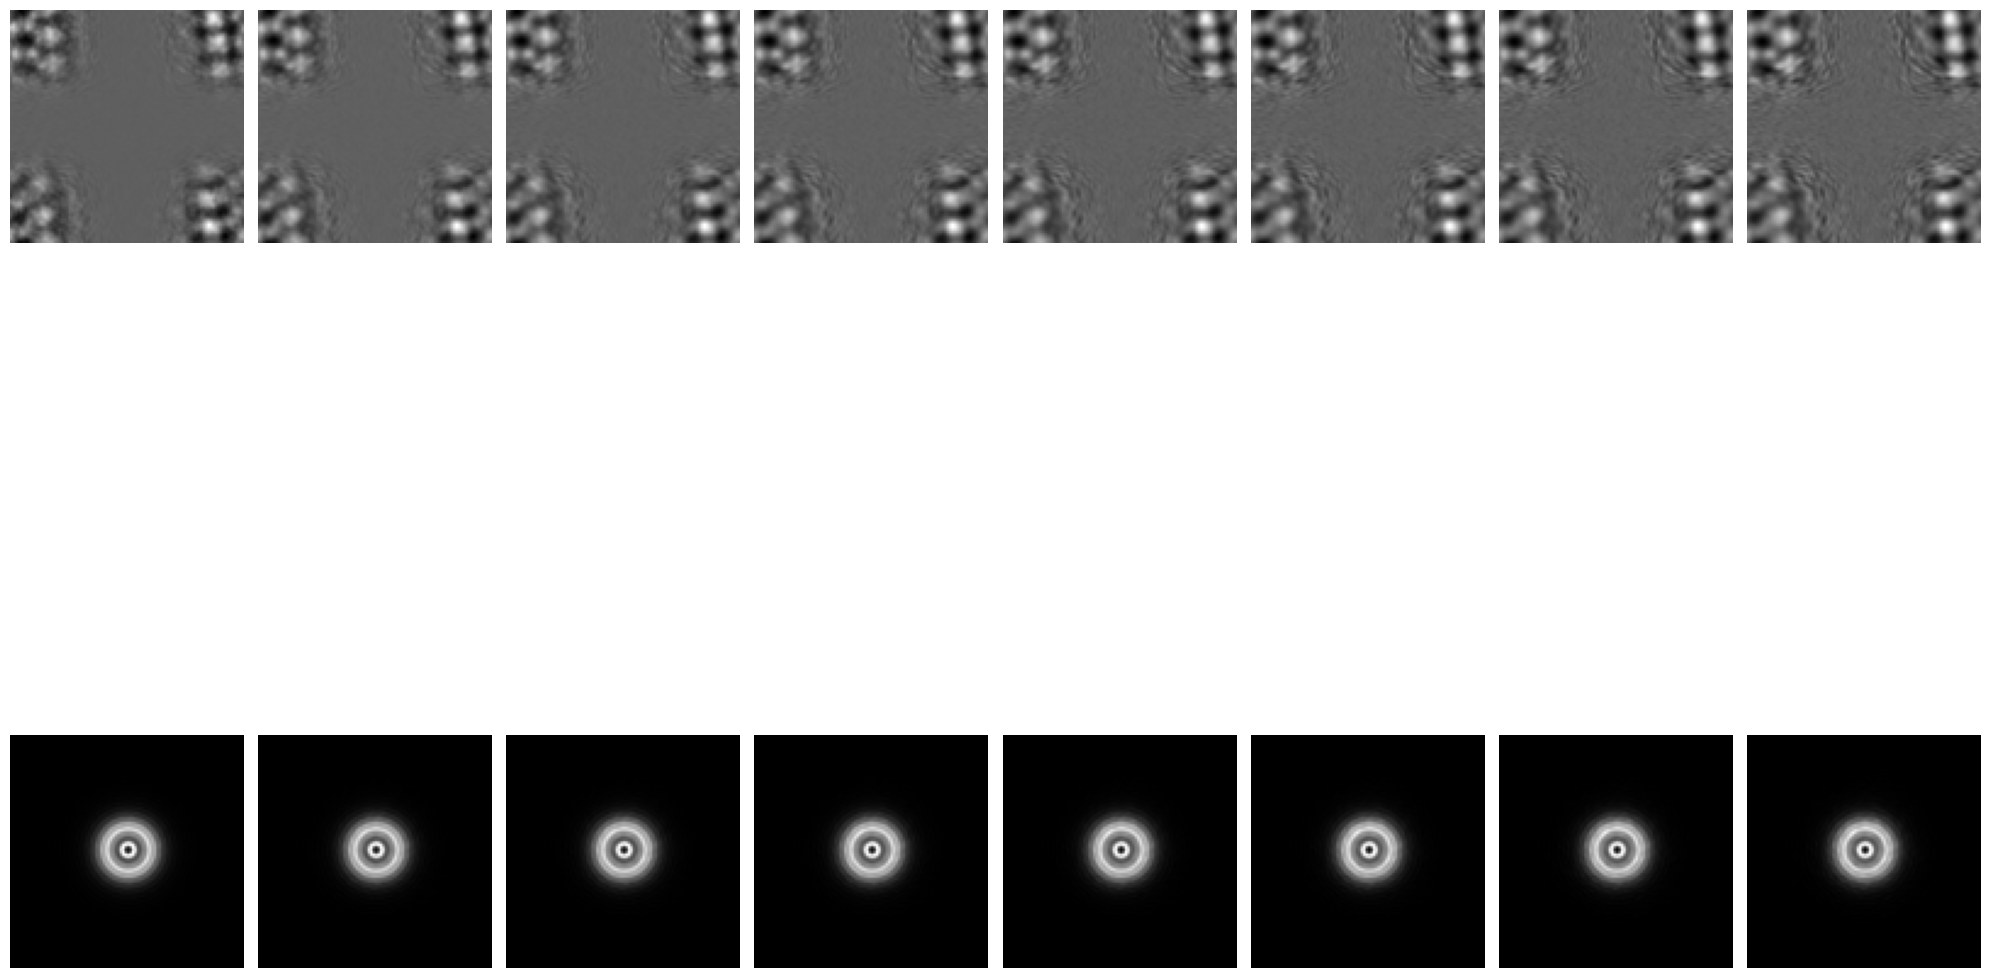

In [25]:
#%matplotlib inline
plot_every = 4

fig, axes = plt.subplots(2, int(np.ceil(len(reconstructions[0]) / plot_every)), figsize=(20,20))
for i, j in enumerate(range(0, len(reconstructions[0]), plot_every)):
    axes[0,i].imshow(np.angle(reconstructions[0][j][0].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions[1][j][0].array).T ** 2, origin='lower', cmap='gray')
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
    
plt.tight_layout()

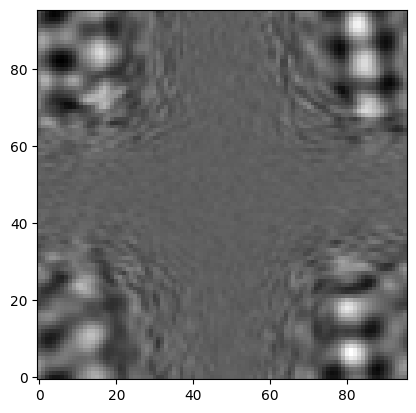

In [26]:
plt.figure()
plt.imshow(np.angle(reconstructions[0][j][0].array).T, origin='lower', cmap='gray')